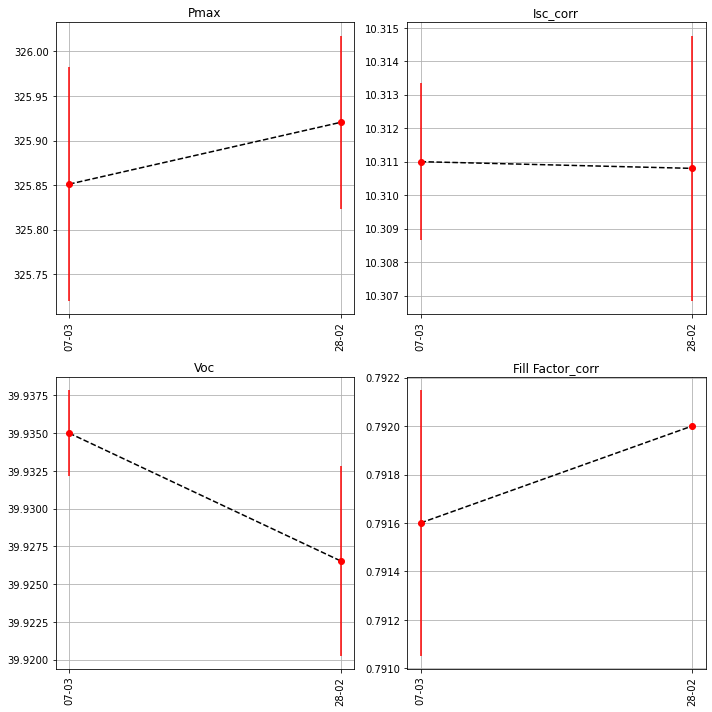

In [3]:

import os
from pathlib import Path

import matplotlib.pyplot as plt

import PVcharacterization_Utils as pv

in_dir = Path(r'C:\Users\franc\PVcharacterization_files\suivi_module_test')
file_list = os.listdir(in_dir)

df_meta = pv.build_df_meta_test_control([in_dir / Path(file) for file in file_list])

list_params = pv.select_params()

df_meta['date'] = df_meta['date'].dt.strftime('%d-%m')
df_meta_mean = df_meta.groupby('date').aggregate('mean')
df_meta_std = df_meta.groupby('date').aggregate('std')


fig, ax = plt.subplots(2, 2,figsize=(10,10))
for idx, param in enumerate(list_params):
    
    ax[idx//2,idx%2].errorbar(df_meta_mean.index,
                              df_meta_mean[param].tolist(),
                              df_meta_std[param],
                              fmt='o',
                              color='r' )
    #ax[idx//2,idx%2].errorbar(x, y, yerr=.1, fmt='', )
    ax[idx//2,idx%2].plot(df_meta_mean.index ,df_meta_mean[param].tolist(),'--k' )
    ax[idx//2,idx%2].set_title(param)
    ax[idx//2,idx%2].tick_params(axis='x',labelrotation=90)
    ax[idx//2,idx%2].grid()
plt.tight_layout()
plt.show()

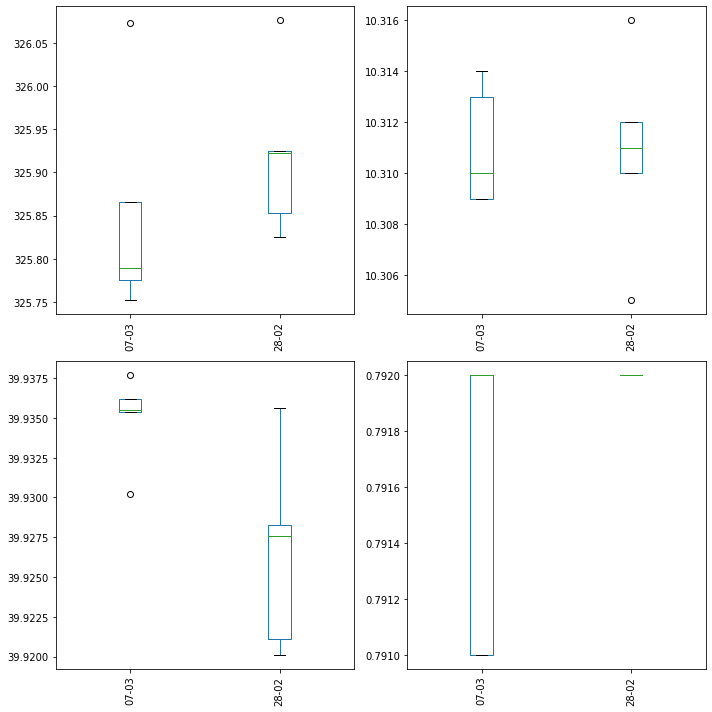

In [4]:
import pandas as pd
fig, ax = plt.subplots(2, 2,figsize=(10,10))

for  idx,param in enumerate(list_params):

    dg = pd.DataFrame.from_dict({date:dg[param].values for date,dg in df_meta.groupby('date')})

    dg.boxplot(ax=ax[idx//2,idx%2]) 
    ax[idx//2,idx%2].tick_params(axis='x',labelrotation=90)
    ax[idx//2,idx%2].grid()
plt.tight_layout()
plt.show()
    